In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/nips_2016-2020.csv')
data.info()
abstract = list(data.ABSTRACT)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7915 entries, 0 to 7914
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   YEAR          7915 non-null   int64 
 1   TITLE         7915 non-null   object
 2   Authors       7915 non-null   object
 3   Paper Link    7915 non-null   object
 4   ABSTRACT      7915 non-null   object
 5   Affiliations  7915 non-null   object
dtypes: int64(1), object(5)
memory usage: 371.1+ KB


In [3]:
data.head(3)

,YEAR,TITLE,Authors,Paper Link,ABSTRACT,Affiliations
0,2016,Improved Dropout for Shallow and Deep Learning,"Zhe Li, Boqing Gong, Tianbao Yang",https://nips.cc/Conferences/2016/Schedule?show...,Dropout has been witnessed with great success ...,"['The University of Iowa', 'University of Cent..."
1,2016,Communication-Optimal Distributed Clustering,"Jiecao Chen, He Sun, David Woodruff, Qin Zhang",https://nips.cc/Conferences/2016/Schedule?show...,Clustering large datasets is a fundamental pro...,"['Indiana University Bloomington', 'The Univer..."
2,2016,On Robustness of Kernel Clustering,"Bowei Yan, Purnamrita Sarkar",https://nips.cc/Conferences/2016/Schedule?show...,Clustering is an important unsupervised learni...,"['University of Texas at Austin', 'U.C. Berkel..."


In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR})")
    print(f"Abstract: {s.ABSTRACT}\n")

Memory-Efficient Approximation Algorithms for Max-k-Cut and Correlation Clustering (NeurIPS2021)
Abstract: Max-k-Cut and correlation clustering are fundamental graph partitioning problems. For a graph $G=(V,E)$ with $n$ vertices, the methods with the best approximation guarantees for Max-k-Cut and the Max-Agree variant of correlation clustering involve solving SDPs with $\mathcal{O}(n^2)$ constraints and variables. Large-scale instances of SDPs, thus, present a memory bottleneck. In this paper, we develop simple polynomial-time Gaussian sampling-based algorithms for these two problems that use $\mathcal{O}(n+|E|)$ memory and nearly achieve the best existing approximation guarantees. For dense graphs arriving in a stream, we eliminate the dependence on $|E|$ in the storage complexity at the cost of a slightly worse approximation ratio by combining our approach with sparsification.

Sanity Checks for Lottery Tickets: Does Your Winning Ticket Really Win the Jackpot? (NeurIPS2021)
Abstract

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

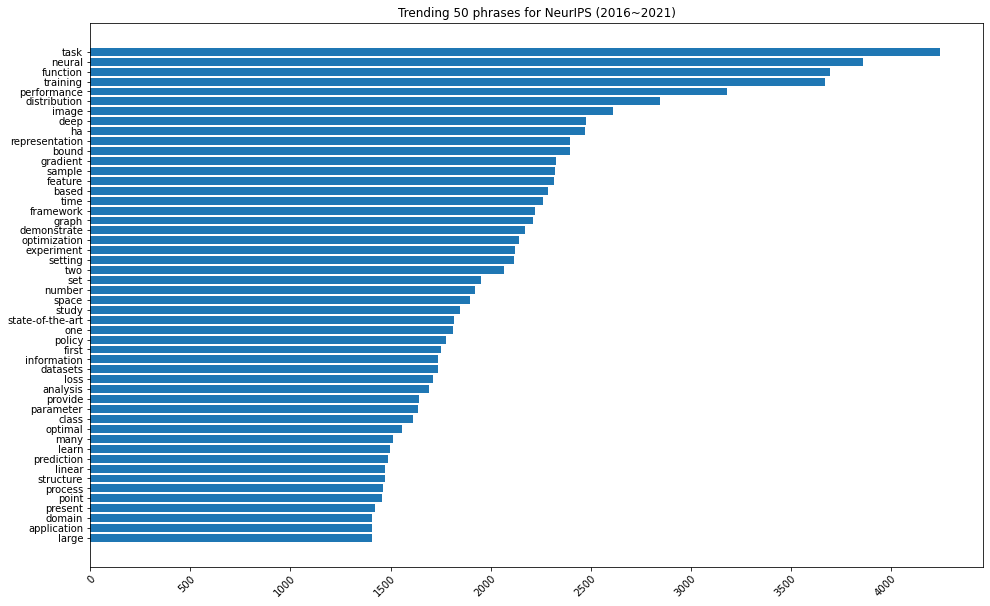

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for NeurIPS (2016~2021)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

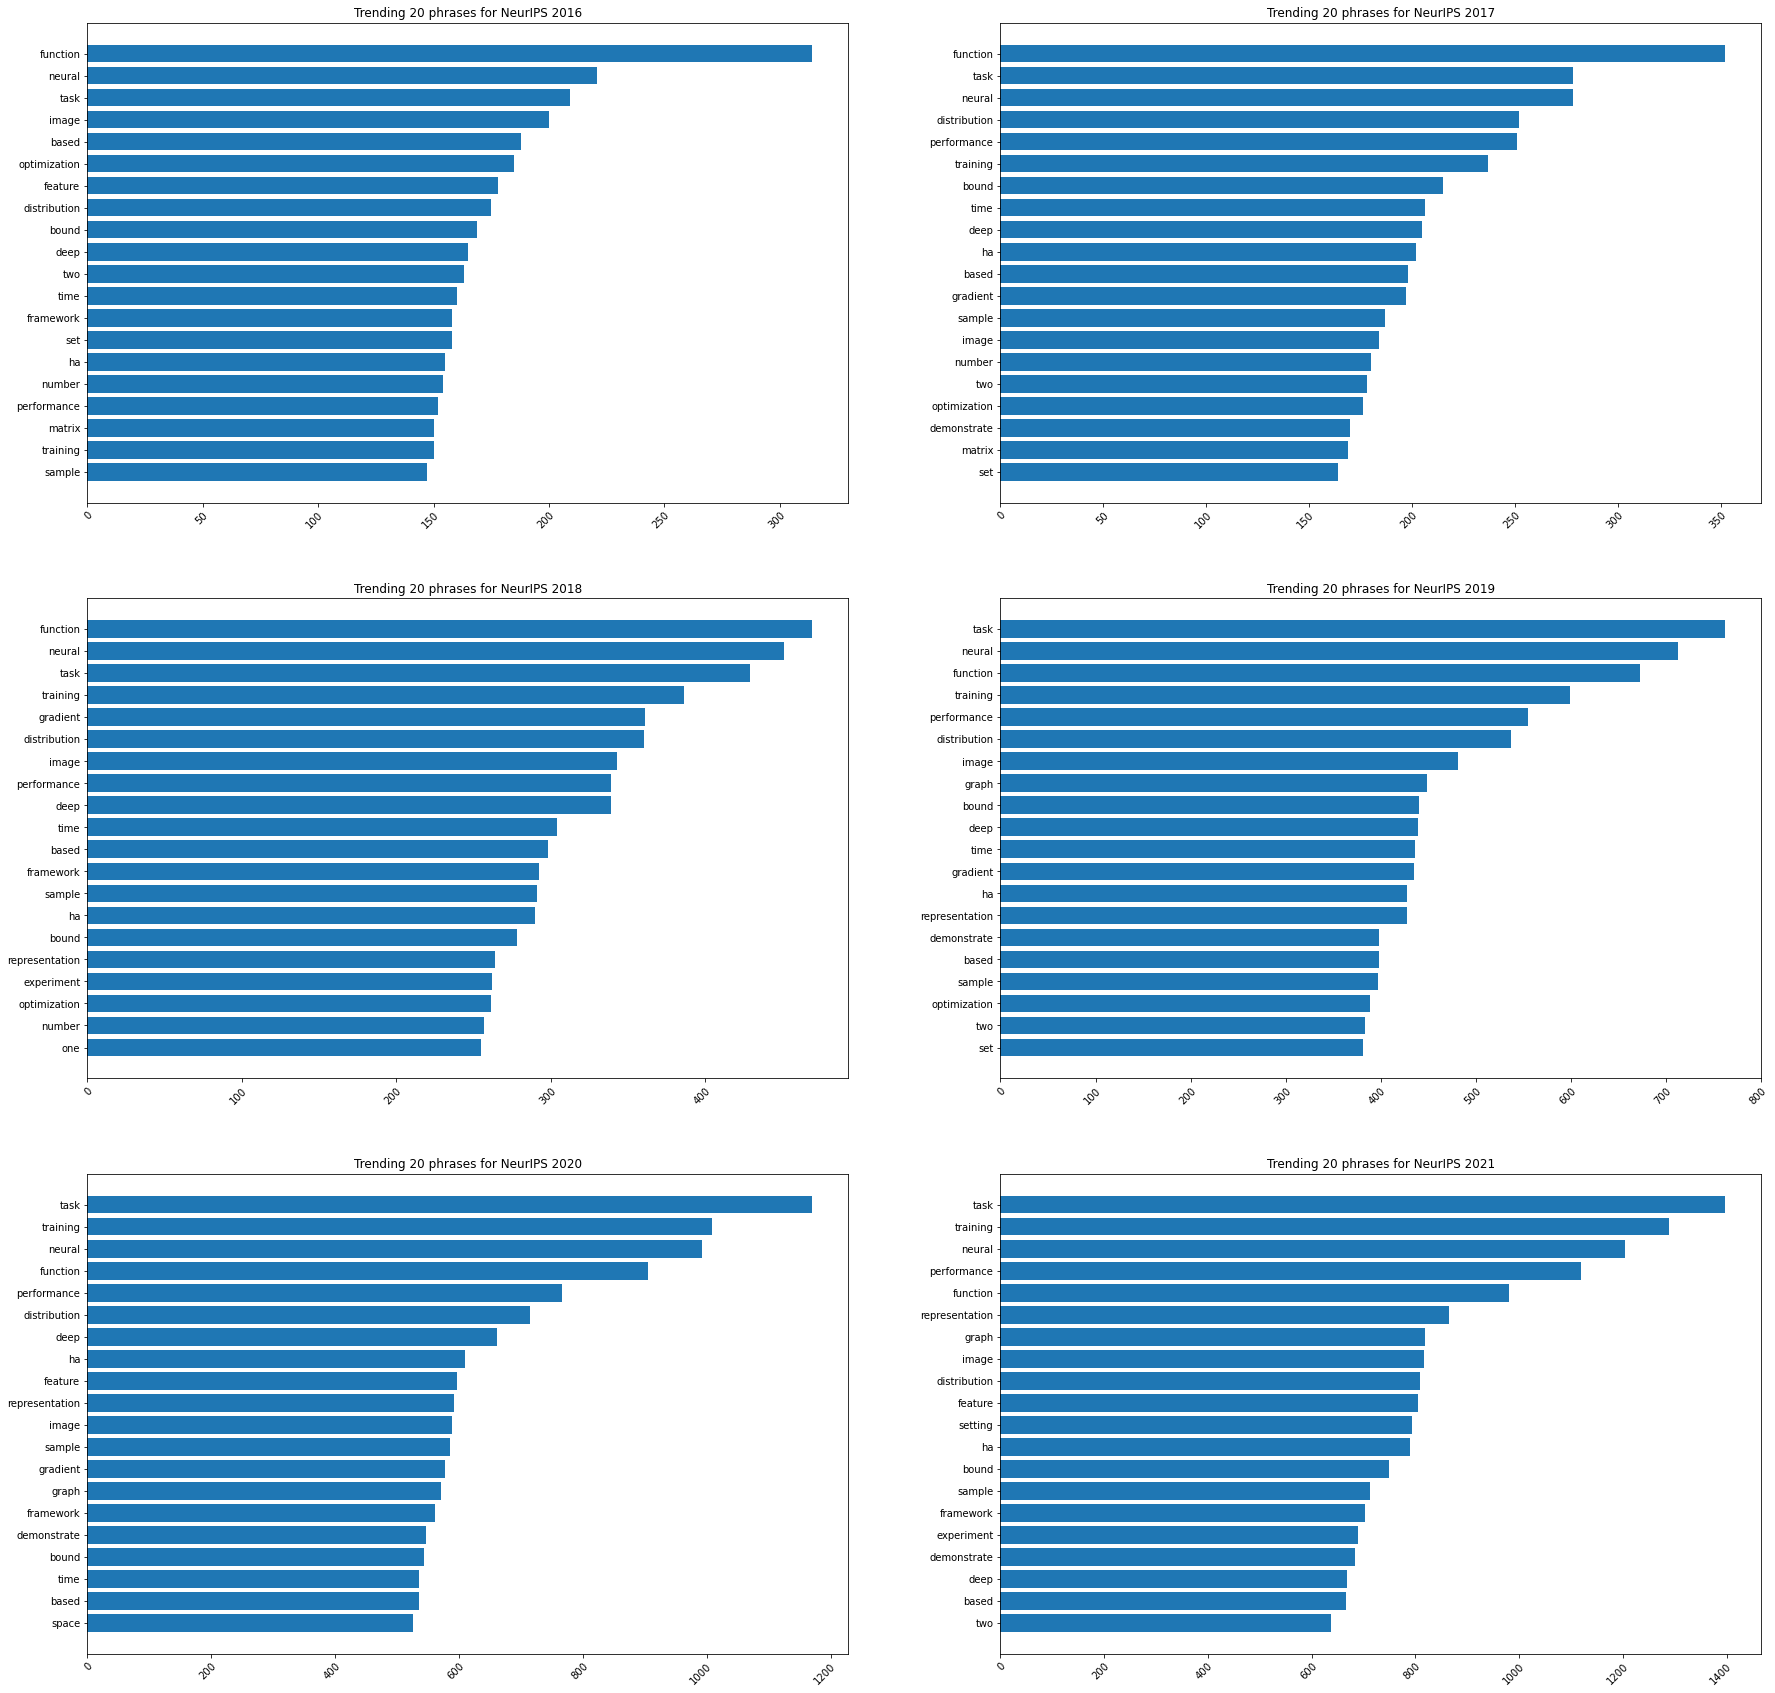

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(3, 2, figsize=(30, 30))
for year, ax in zip(range(2016, 2022), axes.reshape(-1)):
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for NeurIPS {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

plt.show()

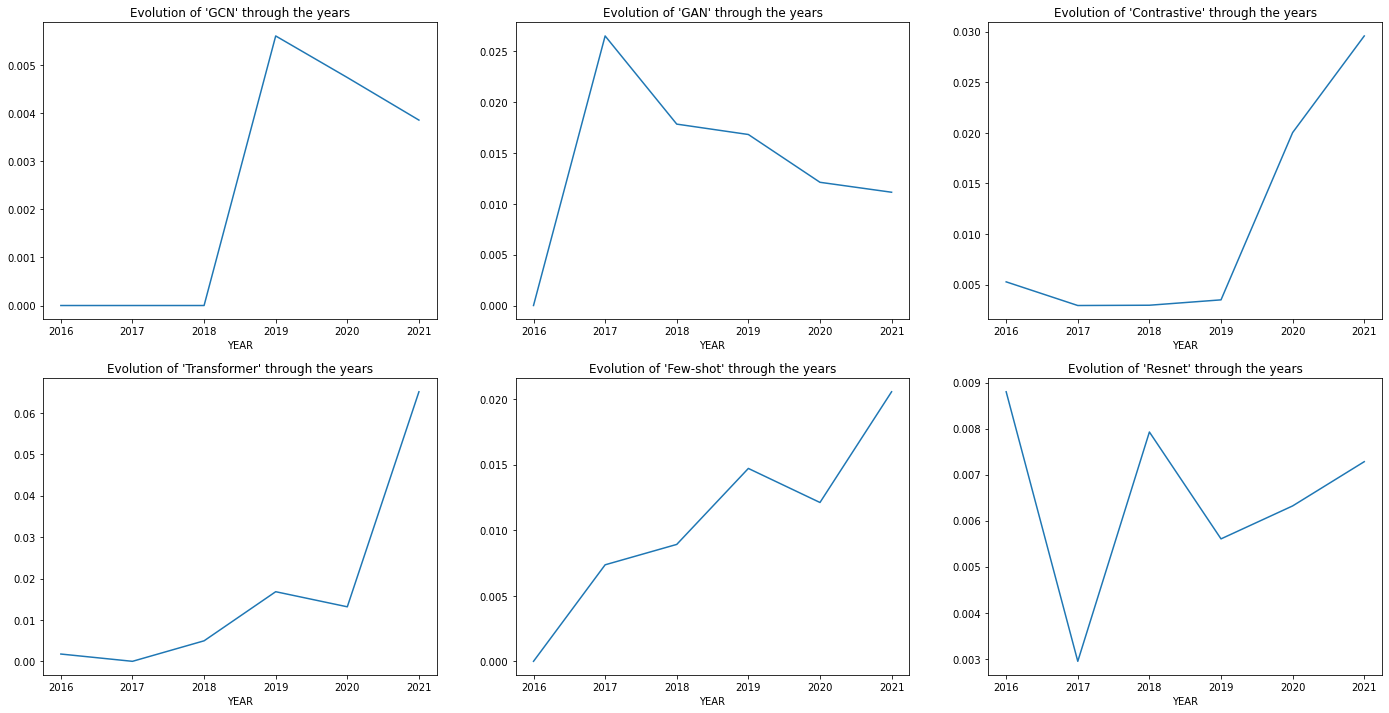

In [10]:
def trace_word_popularity(word):
    assert isinstance(word, str)
    word = word.strip().lower().translate(table)
    assert isinstance(diversity_papers, pd.DataFrame)
    is_word_in_list = np.array([feat==word for feat in tf_vectorizer.get_feature_names_out()])
    if not is_word_in_list.any():
        raise Exception("Couldn't find the word you were looking for.")
        
    if len(word.split()) > 1:
        raise Exception("Must be a 1 word long token separated by spaces.")
    
    total = diversity_papers.groupby('YEAR').count()

    word_idx = np.argwhere(is_word_in_list).item()
    count_df = (diversity_papers.groupby('YEAR').sum().n_themes
                .apply(lambda row: np.array(row))
                .apply(lambda row: row[row == word_idx].size).div(total.n_themes))
    return count_df

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
test_words = ["GCN", "GAN", "Contrastive", "Transformer", "Few-shot", "Resnet"]
for w, ax in zip(test_words, axes.reshape(-1)):
    counts = trace_word_popularity(w)
    counts.plot(ax=ax)
    ax.set_xticks(range(2016, 2022))
    ax.set_title(f"Evolution of '{w}' through the years")

In [11]:
#number of topics
n_topics=6

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=123, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [12]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [13]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

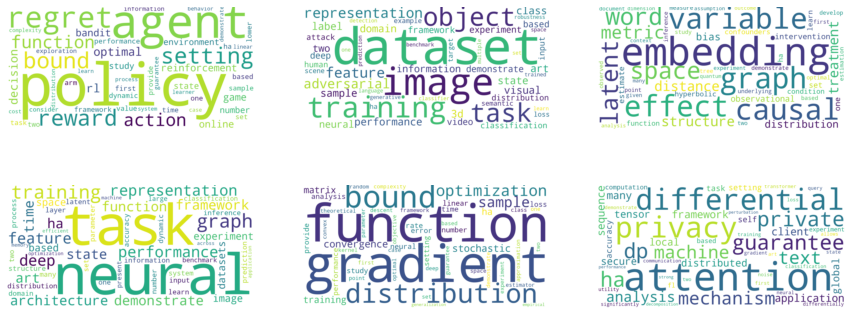

In [14]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [15]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7915 samples in 0.003s...
[t-SNE] Computed neighbors for 7915 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7915
[t-SNE] Computed conditional probabilities for sample 2000 / 7915
[t-SNE] Computed conditional probabilities for sample 3000 / 7915
[t-SNE] Computed conditional probabilities for sample 4000 / 7915
[t-SNE] Computed conditional probabilities for sample 5000 / 7915
[t-SNE] Computed conditional probabilities for sample 6000 / 7915
[t-SNE] Computed conditional probabilities for sample 7000 / 7915
[t-SNE] Computed conditional probabilities for sample 7915 / 7915
[t-SNE] Mean sigma: 0.002776
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.152054
[t-SNE] KL divergence after 2000 iterations: 0.815938


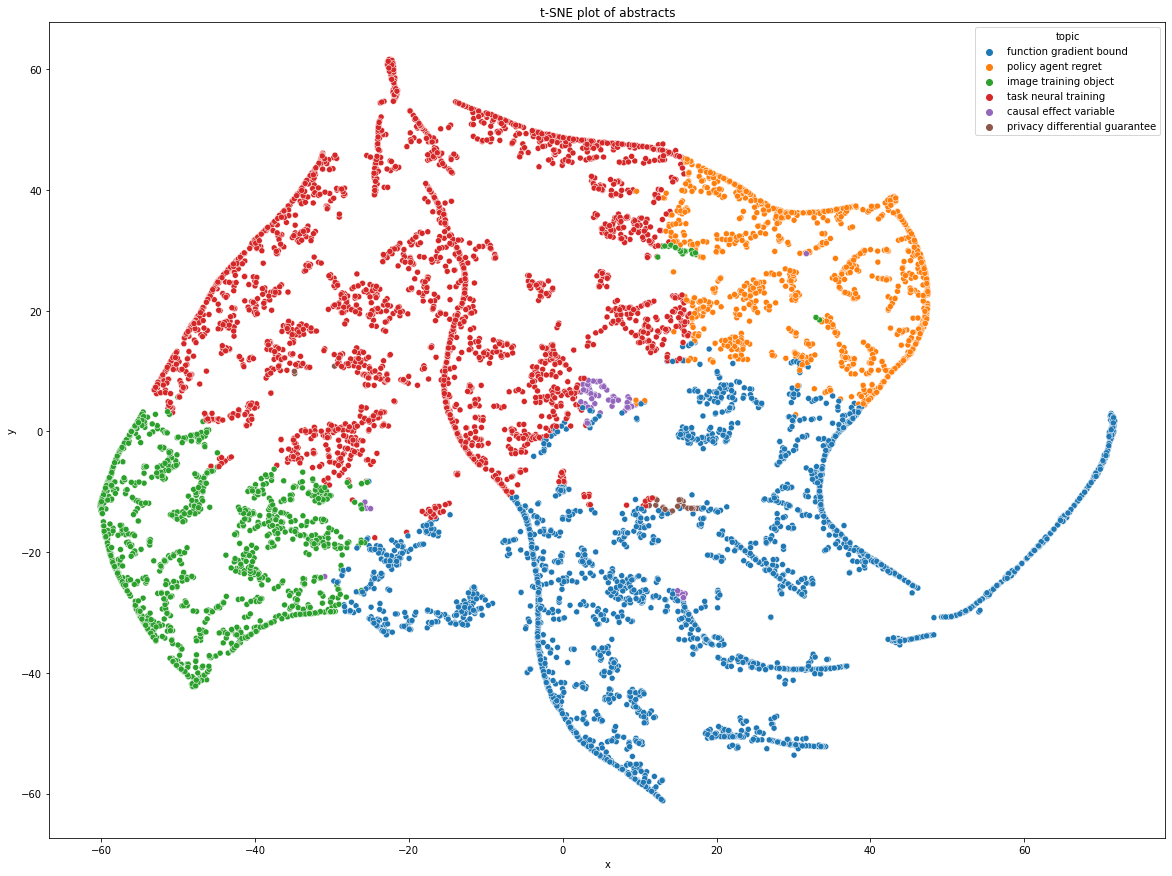

In [16]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE plot of abstracts")
plt.show()

In [17]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: Improved Dropout for Shallow and Deep Learning
 - top 2 topic: (task neural training)+(function gradient bound)

Paper #1: Communication-Optimal Distributed Clustering
 - top 2 topic: (privacy differential guarantee)+(policy agent regret)

Paper #2: On Robustness of Kernel Clustering
 - top 2 topic: (privacy differential guarantee)+(function gradient bound)

Paper #3: Combinatorial semi-bandit with known covariance
 - top 2 topic: (function gradient bound)+(policy agent regret)

Paper #4: A posteriori error bounds for joint matrix decomposition problems
 - top 2 topic: (causal effect variable)+(function gradient bound)



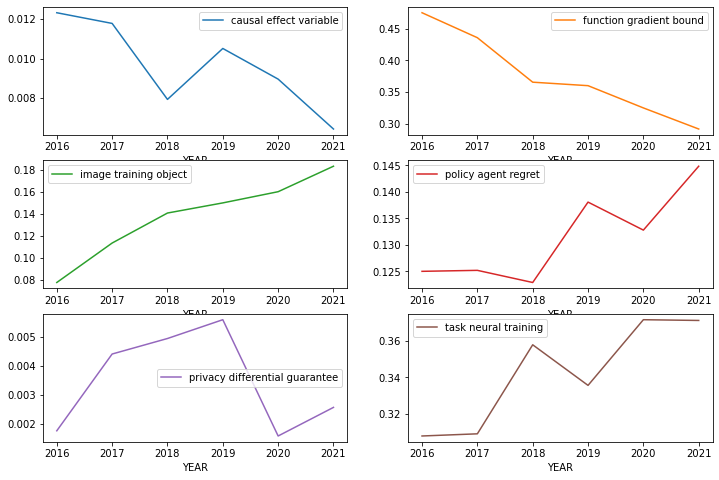

In [18]:
plt.rcParams['figure.figsize'] = (12,8)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, layout=(3, 2))
plt.show()

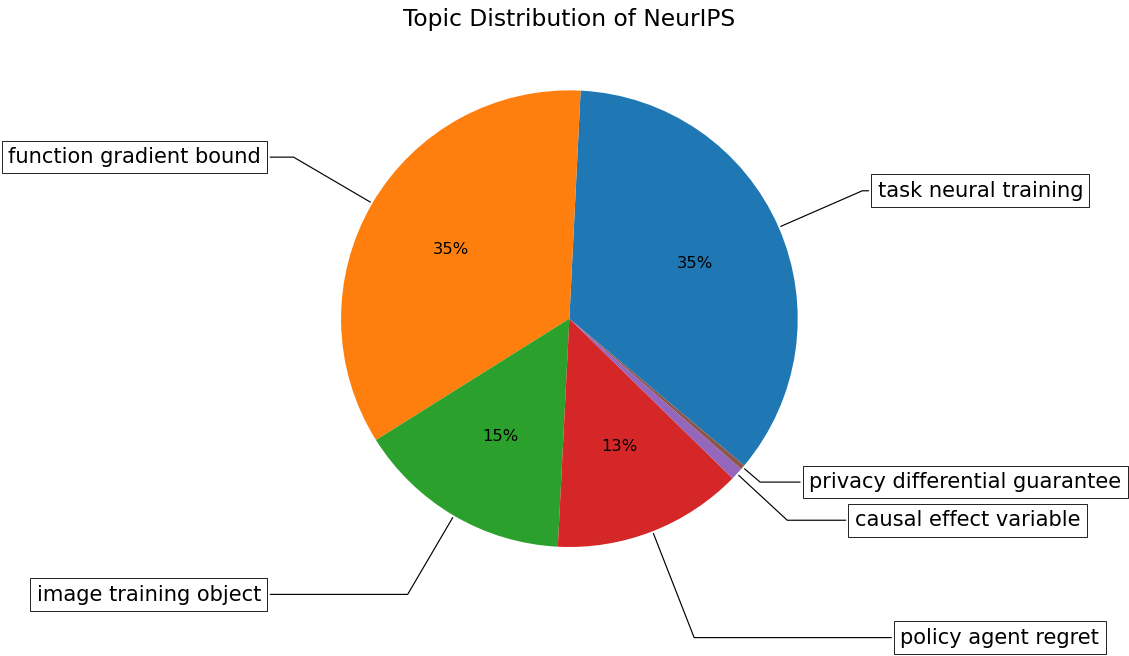

In [19]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

values = np.array(lda_counts)[inds]
labels = np.array(top_3_words_lda)[lda_categories][inds]

wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-40, autopct=make_autopct(values), textprops={'fontsize': 14})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, -0.1, -0.3][i-3] if i > 2 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35+offset)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title("Topic Distribution of NeurIPS", fontsize=20)

plt.show()

In [20]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [26]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [27]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR}): {s.Score:.3f}")

Low-Fidelity Video Encoder Optimization for Temporal Action Localization (NeurIPS2021): 0.647
Detecting Moments and Highlights in Videos via Natural Language Queries (NeurIPS2021): 0.644
Localization with Sampling-Argmax (NeurIPS2021): 0.586
Learning Temporal Pose Estimation from Sparsely-Labeled Videos (NeurIPS2019): 0.571
Temporal Coherency based Criteria for Predicting Video Frames using Deep Multi-stage Generative Adversarial Networks (NeurIPS2017): 0.567
e-SNLI: Natural Language Inference with Natural Language Explanations (NeurIPS2018): 0.547
Towards Interpretable Natural Language Understanding with Explanations as Latent Variables (NeurIPS2020): 0.536
Blind Video Temporal Consistency via Deep Video Prior (NeurIPS2020): 0.526
Foreground Clustering for Joint Segmentation and Localization in Videos and Images (NeurIPS2018): 0.525
Semantic-Guided Multi-Attention Localization for Zero-Shot Learning (NeurIPS2019): 0.525


In [28]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR}): {s.Score:.3f}")

Adversarial training for free! (CVPR2019): 0.688
On Adversarial Mixup Resynthesis (CVPR2019): 0.645
MRI Banding Removal via Adversarial Training (CVPR2020): 0.616
Gradient-Free Adversarial Training Against Image Corruption for Learning-based Steering (CVPR2021): 0.612
Deep Defense: Training DNNs with Improved Adversarial Robustness (CVPR2018): 0.611
Generating steganographic images via adversarial training (CVPR2017): 0.599
Spatial Ensemble: a Novel Model Smoothing Mechanism for Student-Teacher Framework (CVPR2021): 0.594
DM2C: Deep Mixed-Modal Clustering (CVPR2019): 0.590
Boosting Adversarial Training with Hypersphere Embedding (CVPR2020): 0.582
Knowledge Distillation by On-the-Fly Native Ensemble (CVPR2018): 0.571


In [30]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR}): {s.Score:.3f}")

Contrastive Learning from Pairwise Measurements (NeurIPS2018): 0.567
Adversarial Surrogate Losses for Ordinal Regression (NeurIPS2017): 0.551
Nonparametric Density Estimation under Adversarial Losses (NeurIPS2018): 0.539
Multilabel reductions: what is my loss optimising? (NeurIPS2019): 0.534
Provable Guarantees for Self-Supervised Deep Learning with Spectral Contrastive Loss (NeurIPS2021): 0.531
SNIPS: Solving Noisy Inverse Problems Stochastically (NeurIPS2021): 0.510
Max-Margin Invariant Features from Transformed Unlabelled Data (NeurIPS2017): 0.509
Inverse Problems Leveraging Pre-trained Contrastive Representations (NeurIPS2021): 0.506
Learning from Bad Data via Generation (NeurIPS2019): 0.493
Learning the optimal Tikhonov regularizer for inverse problems (NeurIPS2021): 0.489


In [34]:
import pickle
with open("./saved_models/lda_nips.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [35]:
np.save("./saved_models/matrix_nips.npy", lda_topic_matrix)